In [88]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM
import matplotlib.pyplot as plt
import pickle

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Aerotek_Resume_Classification.csv to Aerotek_Resume_Classification.csv


In [89]:
df = pd.read_csv("Aerotek_Resume_Classification.csv")

In [90]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [91]:
df['Resume'] = df['Resume'].astype('string')

In [92]:
df.dtypes

Category    object
Resume      string
dtype: object

Label Encoding

In [93]:
encoder = LabelEncoder()
for i in df.columns:
    if df[i].dtype == object:
        df[i] = encoder.fit_transform(df[i])

In [94]:
df.head()

,Category,Resume
0,0,Skills * Programming Languages: Python (pandas...
1,0,Education Details May 2013 to May 2017 B.E ...
2,0,"Areas of Interest Deep Learning, Control Syste..."
3,0,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,0,"Education Details MCA YMCAUST, Faridabad..."


In [95]:
df.dtypes

Category     int64
Resume      string
dtype: object

Data Cleaning

In [96]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
stop = stopwords.words('english')

In [98]:
def resume_cleaner(Resume):
    Resume = Resume.lower()
    Resume = re.sub('http\S+',' ',Resume,flags = re.MULTILINE)
    Resume = re.sub("[^a-z]"," ",Resume)
    Resume = re.sub('\.+',' ',Resume,flags = re.MULTILINE)
    words = Resume.split()
    imp_words = [w for w in words if w  not in stop]
    
    return " ".join(imp_words)

In [99]:
df['cleaned_Resume'] = df['Resume'].apply(lambda x : resume_cleaner(x))

In [100]:
x = df['cleaned_Resume']
y = df['Category']

In [101]:
df['cleaned_Resume'] = df['cleaned_Resume'].astype('string')

In [102]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=3)


In [103]:
tok = Tokenizer(oov_token='<UNK>')

In [104]:
tok.fit_on_texts(x_train)

In [105]:
len(tok.word_index)

7126

In [106]:
x_train = tok.texts_to_sequences(x_train)
x_test = tok.texts_to_sequences(x_test)

In [107]:
np.mean(df['cleaned_Resume'].apply( lambda x : len(x.split())))

316.24844074844077

In [108]:
x_train = pad_sequences(x_train,maxlen = 80,padding = 'pre',truncating = 'pre',value = 0.0)
x_test = pad_sequences(x_test,maxlen = 80,padding = 'pre',truncating = 'pre',value = 0.0)

In [109]:
df.shape

(962, 3)

Model Building

In [115]:
model = Sequential([Embedding(len(tok.word_index ) +1, 300),
                    LSTM(256),
                    Dense(50,activation = 'relu'),
                    Dense(6,activation = 'softmax')])

In [116]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         2138100   
                                                                 
 lstm_5 (LSTM)               (None, 256)               570368    
                                                                 
 dense_10 (Dense)            (None, 50)                12850     
                                                                 
 dense_11 (Dense)            (None, 6)                 306       
                                                                 
Total params: 2,721,624
Trainable params: 2,721,624
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(optimizer='Adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [118]:
history = model.fit(x_train,y_train,epochs=5,batch_size=700,validation_data=[x_test,y_test])

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 1.7923 - accuracy: 0.1753 - val_loss: 1.7768 - val_accuracy: 0.5225
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 1.7764 - accuracy: 0.5319 - val_loss: 1.7602 - val_accuracy: 0.5675
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 1.7594 - accuracy: 0.5706 - val_loss: 1.7389 - val_accuracy: 0.5744
Epoch 4/5
1/1 [==============================] - 6s 6s/step - loss: 1.7376 - accuracy: 0.5795 - val_loss: 1.7093 - val_accuracy: 0.5709
Epoch 5/5
1/1 [==============================] - 5s 5s/step - loss: 1.7074 - accuracy: 0.5750 - val_loss: 1.6654 - val_accuracy: 0.5675


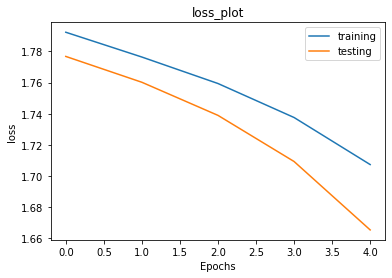

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('loss_plot')
plt.legend(['training','testing'])

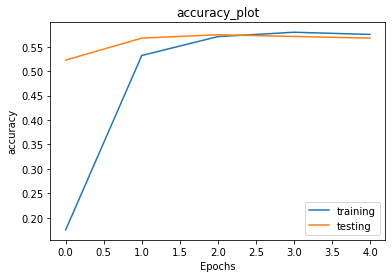

In [120]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('accuracy_plot')
plt.legend(['training','testing'])

In [121]:
model.save('LSTM_model.h5')

In [122]:
with open('tokinization.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)